## 11.6 Self-Attention and Positional Encoding

In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 11.6.1 Self-Attention

Given a sequence of input tokens $\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_n$ where any $\mathbf{x}_i \in \mathbb{R}^{d}$, its self-attention outputs a sequence of the same length $\mathbf{y}_1, \mathbf{y}_2, ..., \mathbf{y}_n$ where

$$
\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), ..., (\mathbf{x}_n, \mathbf{x}_n))
$$

Using multi-head attention, the following code snippet computes the self-attention of a tensor with shape (batch size, number of time steps or sequence length in tokens, d). The output tensor has the same shape.

In [3]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
d2l.check_shape(attention(X, X, X, valid_lens),
(batch_size, num_queries, num_hiddens))

/home/solee/miniconda3/envs/dive2dl/lib/python3.7/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## 11.6.2 Comparing CNNs, RNNs and Self-Attention

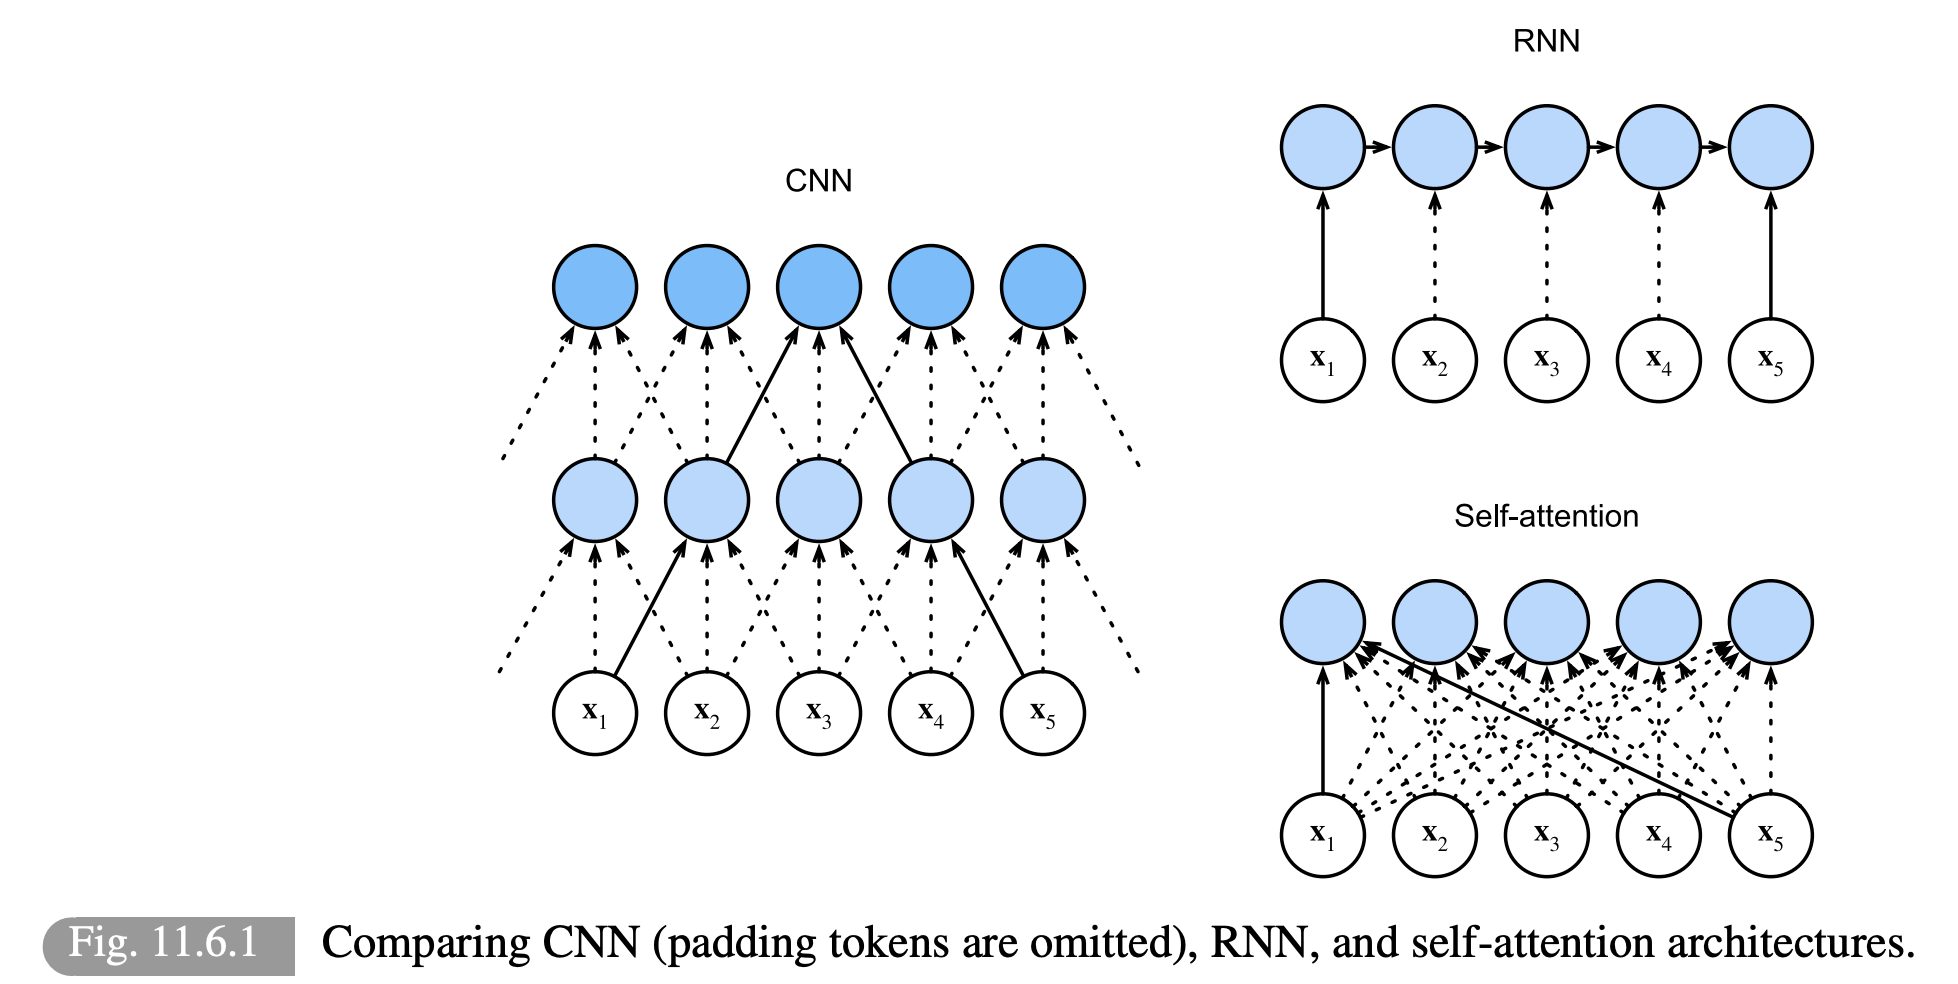

## 11.6.3 Positional Encoding

Unlike RNNs, which recurrently process tokens of a sequence one-by-one, self-attention ditches sequential operations in favor of parallel computation. Note that self-attention by itself does not preserve the order of the sequence. What do we do if it really matters that the model knows in which order the input sequence arrived?

The dominant approach for preserving information about the order of tokens is to represent this to the model as an additional input associated with each token. These inputs are called positional encodings, and they can either be learned or fixed a priori.

Suppose that the input representation $\mathbf{X} \in \mathbb{R}^{n \times d}$ contains the d-dimensional embeddings for n tokens of a sequence. The positional encoding outputs $\mathbb{X} + \mathbb{P}$ using a positional embedding matrix $\mathbf{P} \in \mathbb{R}^{n \times d}$ of the same shape, whose element on the $i$th row and the $2j$th or the $(2j + 1)$th column is

$$
p_{i, 2j} = sin(\cfrac{i}{10000^{2j/d}})\\
p_{i, 2j+1} = cos(\cfrac{i}{10000^{2j/d}})
$$

At first glance, this trigonometric function design looks weird. Before we give explanations of this design, let’s first implement it in the following PositionalEncoding class.

In [4]:
class PositionalEncoding(nn.Module): #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(
        0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

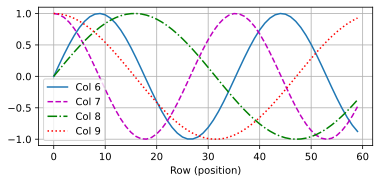

In [5]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])